In [2]:
import sys
# CausalML is not supported for Pyhon 2.7
if sys.version_info < (3, 0):
    exit(0)

# Uplift random forest modeling - H2O-3 vs. CausalML

In [3]:
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_plot
from causalml.metrics import plot_gain, plot_qini, plot_lift
from causalml.metrics import auuc_score

import h2o
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

import pandas as pd
from IPython.display import Image

In [4]:
control_name = "control"
treatment_column = "treatment"
response_column = "outcome"
feature_cols = ["feature_"+str(x) for x in range(1,13)]

train_df = pd.read_csv("../../smalldata/uplift/upliftml_train.csv")
test_df = pd.read_csv("../../smalldata/uplift/upliftml_test.csv")

train_df[treatment_column].replace({1: "treatment", 0: "control"}, inplace=True)
test_df[treatment_column].replace({1: "treatment", 0: "control"}, inplace=True)
train_df.shape, test_df.shape

((4989, 17), (5011, 17))

In [5]:
ntree = 40
max_depth = 10
metric_cml="EU"
metric_h2o="Euclidean"

# CausalML

In [6]:
# Train CausalML uplift tree
causalml_uplift_model = UpliftRandomForestClassifier(
        n_estimators=ntree,
        max_depth=max_depth,
        evaluationFunction=metric_cml,
        control_name=control_name,
        min_samples_leaf=10,
        min_samples_treatment=0,
        normalization=False,
        random_state=42)

causalml_uplift_model.fit(train_df[feature_cols].values,
                 treatment=train_df[treatment_column].values,
                 y=train_df[response_column].values)

#test_df = train_df
causalml_preds = causalml_uplift_model.predict(test_df.values)

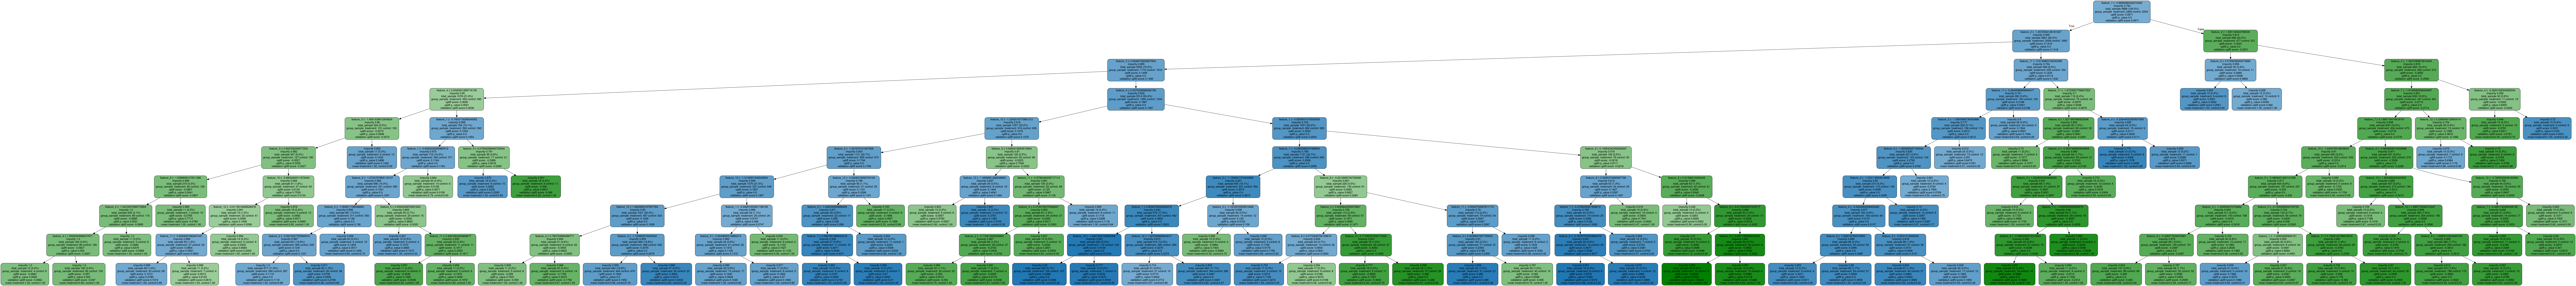

In [7]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[2].fitted_uplift_tree, feature_cols)
Image(graph.create_png())

# H2O-3

In [8]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         35 secs
H2O_cluster_timezone:       Europe/Berlin
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.37.0.99999
H2O_cluster_version_age:    5 days
H2O_cluster_name:           mori
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    4.816 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.7.3 candidate
--------------------------  -----------------------------

In [9]:
train_h2o = h2o.H2OFrame(train_df)
train_h2o[treatment_column] = train_h2o[treatment_column].asfactor()
train_h2o[response_column] = train_h2o[response_column].asfactor()
h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            treatment_column=treatment_column,
            uplift_metric=metric_h2o,
            min_rows=10,
            nbins=1000,
            seed=42,
            sample_rate=0.50,
            auuc_type="gain",
            score_each_iteration=False)
h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=train_h2o)
h2o_uplift_model

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1649683204366_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               40.0                      80.0              22666.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        9.0        9.0         9.0        10.0        30.0        18.05



ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 401.1709940041244
AUUC normalized: 0.936269349589571

AUUC table: All types of AUUC value


uplift_type        qini      lift        gain
0         AUUC value  199.611020  0.198039  401.170994
1    AUUC normalized    0.927075  0.198039    0.936269
2  AUUC random value  107.745417  0.042978  214.416388

Qini value: 91.86560354396893

AECU values table: All types of AECU value


uplift_type       qini      lift        gain
0  AECU value  91.865604  0.155062  186.754606


Scoring History: 


timestamp    duration  number_of_trees  training_auuc  \
0     2022-04-11 15:20:41   0.103 sec              0.0     428.392320   
1     2022-04-11 15:20:42   0.661 sec              1.0     332.895495   
2     2022-04-11 15:20:42   0.809 sec              2.0     335.248264   
3     2022-04-11 15:20:42   0.989 sec              3.0     374.008501   
4     2022-04-11 15:20:42   1.208 sec              4.0     374.566325   
5     2022-04-11 15:20:43   1.381 sec              5.0     363.117381   
6     2022-04-11 15:20:43   1.574 sec              6.0     368.369893   
7     2022-04-11 15:20:43   1.772 sec              7.0     364.946222   
8     2022-04-11 15:20:43   1.917 sec              8.0     373.349197   
9     2022-04-11 15:20:43   2.104 sec              9.0     372.175708   
10    2022-04-11 15:20:43   2.242 sec             10.0     368.090454   
11    2022-04-11 15:20:44   2.399 sec             11.0     377.138573   
12    2022-04-11 15:20:44   2.534 sec             12.0     387.586113   
13    2022-04-11 15:20:44   2.661 sec             13.0     399.030541   
14    2022-04-11 15:20:44   2.803 sec             14.0     401.160992   
15    2022-04-11 15:20:44   2.932 sec             15.0     402.960663   
16    2022-04-11 15:20:44   3.066 sec             16.0     399.751448   
17    2022-04-11 15:20:44   3.178 sec             17.0     398.686979   
18    2022-04-11 15:20:44   3.310 sec             18.0     400.596518   
19    2022-04-11 15:20:45   3.474 sec             19.0     400.113599   

    training_auuc_normalized  training_qini_coefficient  
0                   0.999800               5.684342e-14  
1                   0.776925               2.713656e+01  
2                   0.782416               4.924481e+01  
3                   0.872876               7.796130e+01  
4                   0.874178               7.910295e+01  
5                   0.847458               7.392006e+01  
6                   0.859717               7.672739e+01  
7                   0.851726               7.568125e+01  
8                   0.871338               7.978316e+01  
9                   0.868599               7.944335e+01  
10                  0.859065               7.691642e+01  
11                  0.880181               8.157894e+01  
12                  0.904564               8.692309e+01  
13                  0.931274               9.261257e+01  
14                  0.936246               9.322067e+01  
15                  0.940446               9.400376e+01  
16                  0.932956               9.171586e+01  
17                  0.930472               9.109139e+01  
18                  0.934929               9.164269e+01  
19                  0.933802               9.142063e+01


See the whole table with table.as_data_frame()


In [10]:
test_h2o = h2o.H2OFrame(test_df)
test_h2o[treatment_column] = test_h2o[treatment_column].asfactor()
test_h2o[response_column] = test_h2o[response_column].asfactor()
preds_h2o = h2o_uplift_model.predict(test_h2o)

perf_h2o = h2o_uplift_model.model_performance(test_h2o)
auuc_h2o = perf_h2o.auuc()
print("H2O training metrics AUUC Gain: "+str(auuc_h2o))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf prediction progress: |█████████████████████████████████████████████████| (done) 100%
H2O training metrics AUUC Gain: 413.0785009769531


In [11]:
preds_comp = preds_h2o["uplift_predict"]
preds_comp.names = ["h2o"]
preds_comp["causal"] = h2o.H2OFrame(causalml_preds)
preds_comp["diff"] = abs(preds_comp["h2o"] - preds_comp["causal"])
preds_comp[treatment_column] = h2o.H2OFrame(test_df[treatment_column].values)
preds_comp[response_column] = h2o.H2OFrame(test_df[response_column].values)
preds_comp.summary()
    
min_diff = preds_comp["diff"].min()
max_diff = preds_comp["diff"].max()
mean_diff = preds_comp["diff"].mean(return_frame=False)[0]
print("min: %f max: %f mean: %f" % (min_diff, max_diff, mean_diff))

results = preds_comp.as_data_frame()
results = results[["h2o", "causal", response_column, treatment_column]]
mapping = {'control': 0, 'treatment': 1}
results = results.replace({treatment_column: mapping})


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


h2o causal diff treatment outcome 
 
 
 type real real real enum int 
 mins -0.6264740526676178 -0.42471469999999983 0.008620413486886136 0.0 
 mean 0.08160152274589659 -0.3045768187087111 0.3968701345928754 0.7579325483935342 
 maxs 0.4469720799475908 0.02607035000000002 0.7568074273131369 1.0 
 sigma 0.1289023084090676 0.06800603110414812 0.09138011078496905 0.4283776621130897 
 zeros 0 0 0 1213 
 missing 0 167 167 0 0 
 0 -0.041345784440636635 -0.2548313500000001 0.2134855655593635 treatment 0.0 
 1 0.03545406088232994 -0.2769367249999998 0.3123907858823297 treatment 1.0 
 2 0.09025202393531806 -0.34005672499999984 0.4303087489353179 control 0.0 
 3 0.08830580376088626 -0.292167525 0.38047332876088624 control 1.0 
 4 0.08333902284502981 -0.2450239750000001 0.32836299784502987 treatment 0.0 
 5 -0.0022025305777787496 -0.14500962499999992 0.14280709442222117 control 1.0 
 6 0.0757184848189354 -0.3319839000000001 0.4077023848189355 control 1.0 
 7 0.13533128127455707 -0.3155695499999999 0.450900831274557 control 1.0 
 8 0.09469123035669325 -0.267390425 0.36208165535669323 control 0.0 
 9 -0.03024397343397145 -0.3314109999999999 0.30116702656602845 treatment 1.0

min: nan max: nan mean: 0.396870


In [12]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=False)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
411.317388736069
CauslML AUUC:
220.7382958310566
Random AUUC:
234.98047847365325


In [13]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=True)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
0.8456024406679814
CauslML AUUC:
0.45380245721487095
Random AUUC:
0.4830820955983254


## Qini

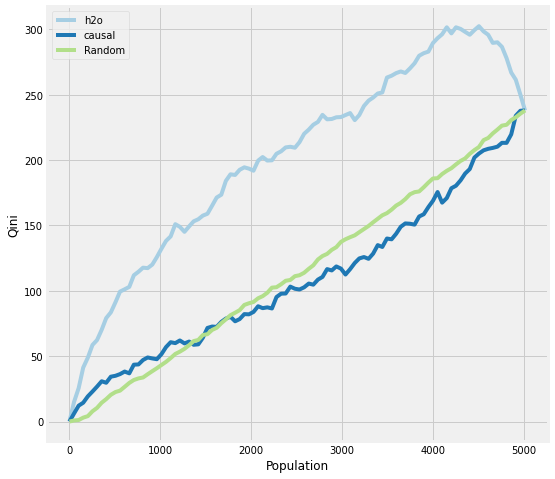

In [14]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column)

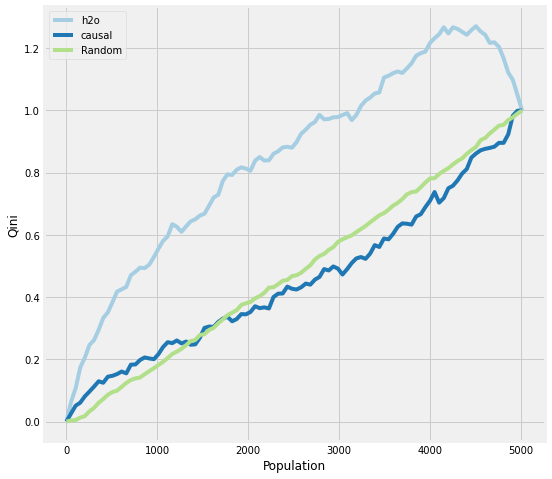

In [15]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column, normalize=True)

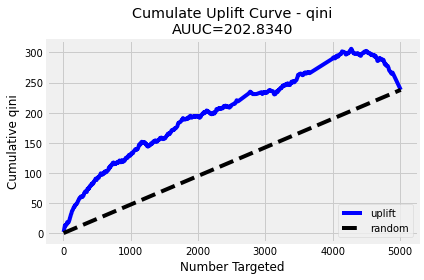

819
[6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 122, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496, 502, 507, 512, 517, 522, 529, 532, 537, 542, 547, 552, 558, 562, 567, 572, 577, 582, 587, 592, 597, 602, 607, 612, 617, 622, 627, 632, 637, 642, 647, 652, 657, 662, 667, 672, 677, 682, 687, 692, 697, 702, 707, 712, 717, 722, 727, 732, 737, 742, 747, 752, 757, 762, 767, 772, 777, 782, 787, 792, 797, 802, 807, 812, 817, 822, 827, 832, 837, 842, 847, 852, 857, 862, 867, 872, 877, 882, 887, 892, 897, 902, 907, 912, 917, 922, 927, 932, 937, 942, 947, 952, 957, 962, 967, 972, 977, 982, 987, 992, 997, 1003, 1008, 1013, 10

In [16]:
perf_h2o.plot_uplift(metric="qini")

n, uplift = perf_h2o.plot_uplift(metric="qini", plot=False)
print(len(n))
print(n)
print(uplift)

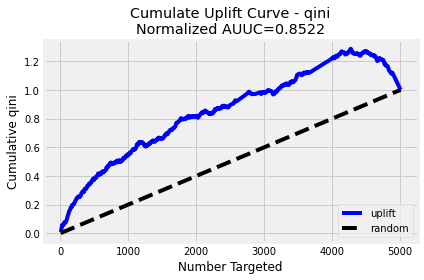

In [17]:
perf_h2o.plot_uplift(metric="qini", normalize=True)

## Lift

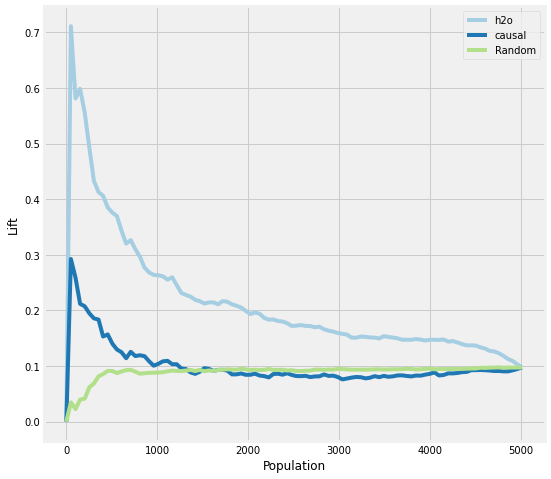

In [18]:
plot_lift(results, outcome_col=response_column, treatment_col=treatment_column)

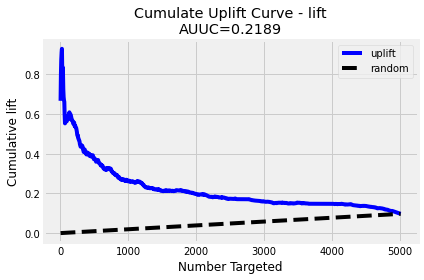

[6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 122, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496, 502, 507, 512, 517, 522, 529, 532, 537, 542, 547, 552, 558, 562, 567, 572, 577, 582, 587, 592, 597, 602, 607, 612, 617, 622, 627, 632, 637, 642, 647, 652, 657, 662, 667, 672, 677, 682, 687, 692, 697, 702, 707, 712, 717, 722, 727, 732, 737, 742, 747, 752, 757, 762, 767, 772, 777, 782, 787, 792, 797, 802, 807, 812, 817, 822, 827, 832, 837, 842, 847, 852, 857, 862, 867, 872, 877, 882, 887, 892, 897, 902, 907, 912, 917, 922, 927, 932, 937, 942, 947, 952, 957, 962, 967, 972, 977, 982, 987, 992, 997, 1003, 1008, 1013, 1018, 

In [19]:
perf_h2o.plot_uplift(metric="lift")

n, uplift = perf_h2o.plot_uplift(metric="lift", plot=False)
print(n)
print(uplift)

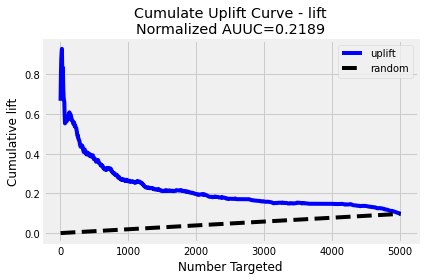

In [23]:
perf_h2o.plot_uplift(metric="lift", normalize=True)

## Gain

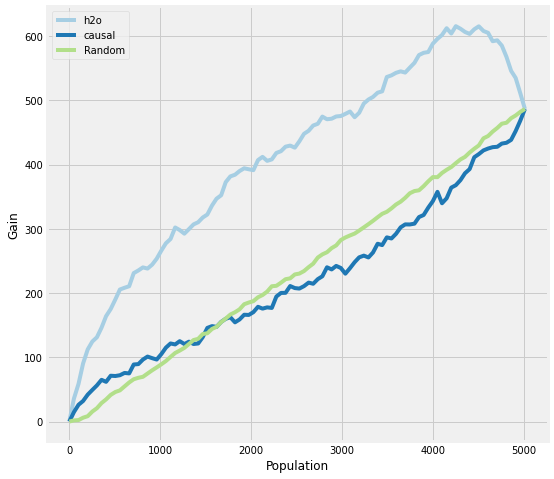

In [24]:
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column)

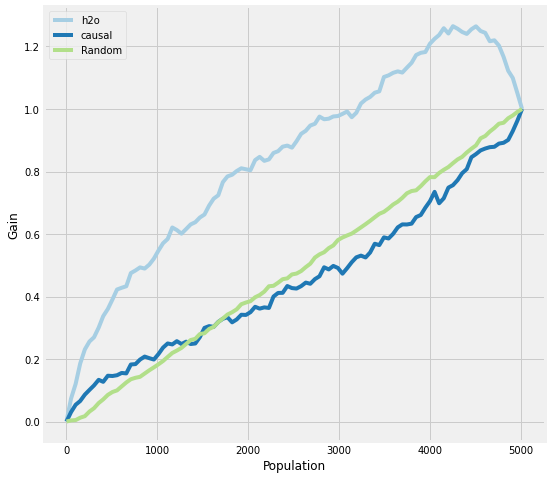

In [25]:
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column, normalize=True)

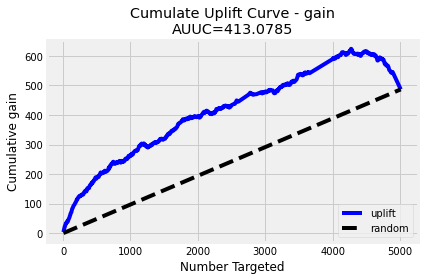

[6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 122, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496, 502, 507, 512, 517, 522, 529, 532, 537, 542, 547, 552, 558, 562, 567, 572, 577, 582, 587, 592, 597, 602, 607, 612, 617, 622, 627, 632, 637, 642, 647, 652, 657, 662, 667, 672, 677, 682, 687, 692, 697, 702, 707, 712, 717, 722, 727, 732, 737, 742, 747, 752, 757, 762, 767, 772, 777, 782, 787, 792, 797, 802, 807, 812, 817, 822, 827, 832, 837, 842, 847, 852, 857, 862, 867, 872, 877, 882, 887, 892, 897, 902, 907, 912, 917, 922, 927, 932, 937, 942, 947, 952, 957, 962, 967, 972, 977, 982, 987, 992, 997, 1003, 1008, 1013, 1018, 

In [23]:
perf_h2o.plot_uplift(metric="gain")

n, uplift = perf_h2o.plot_uplift(metric="gain", plot=False)
print(n)
print(uplift)

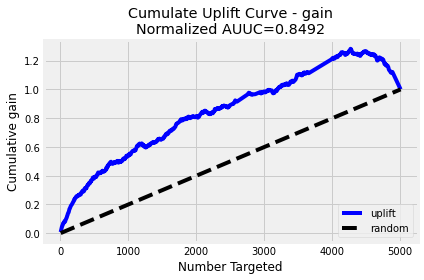

In [26]:
perf_h2o.plot_uplift(metric="gain", normalize=True)